# Análisis Exploratorio de Datos del Titanic
Este notebook contiene un análisis exploratorio de datos (EDA) completo del dataset del Titanic. Exploraremos las características del dataset, crearemos nuevas variables, construiremos modelos predictivos y visualizaremos los resultados.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

In [3]:
# Cargar el dataset
df = pd.read_csv('data/train.csv')

# Exploración inicial
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Realizamos una primera exploración del dataset para entender la estructura de los datos y detectar valores faltantes.

In [4]:
# Imputar valores faltantes
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)

Imputamos los valores faltantes en las columnas `Age`, `Embarked` y `Fare` utilizando la mediana o la moda según corresponda.

In [5]:
# Crear nuevas características
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = df['FamilySize'].apply(lambda x: 1 if x == 1 else 0)
df['FarePerPerson'] = df['Fare'] / df['FamilySize']
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])

Creamos nuevas variables que podrían ser útiles para el análisis y la modelización, como `FamilySize`, `IsAlone`, `FarePerPerson`, y `AgeGroup`.

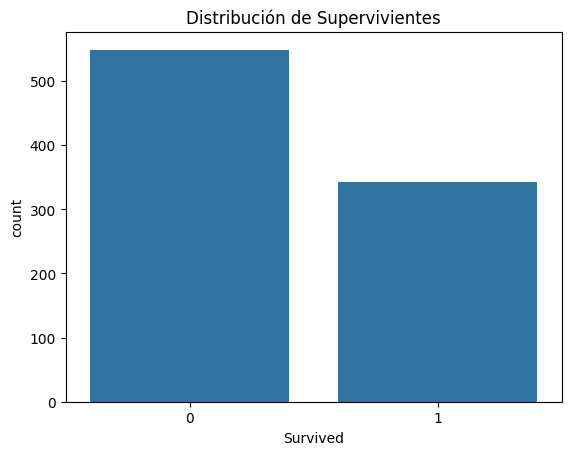

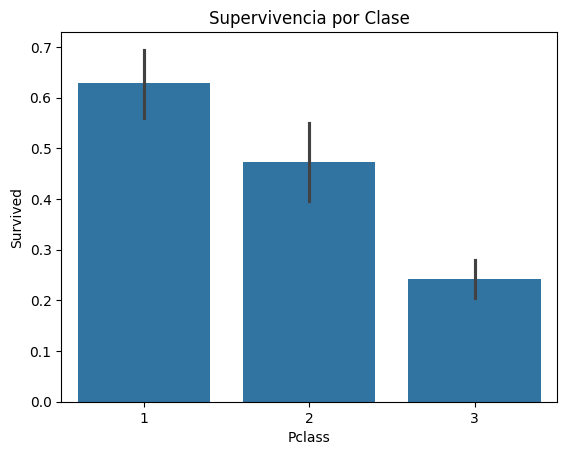

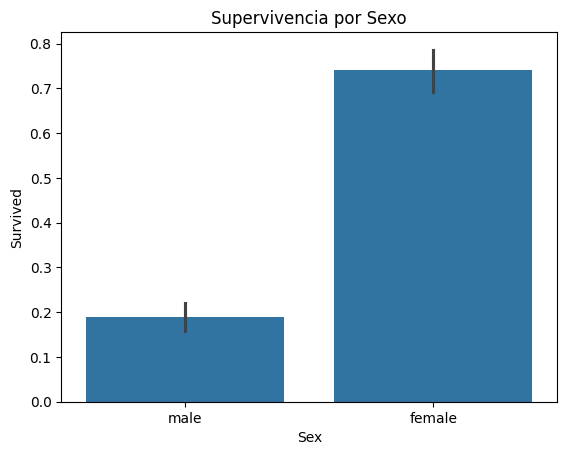

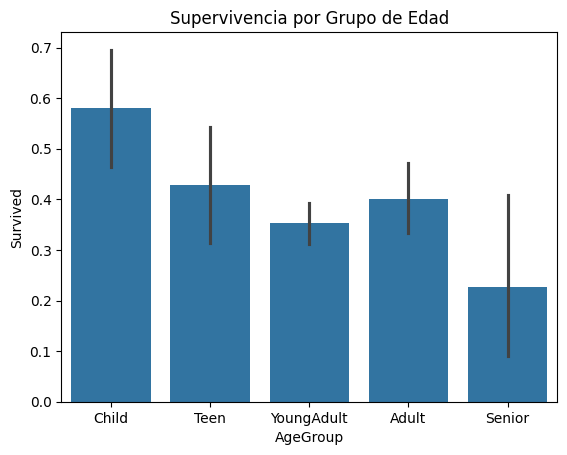

In [6]:
# Distribución de supervivientes
sns.countplot(x='Survived', data=df)
plt.title('Distribución de Supervivientes')
plt.show()

# Análisis de supervivencia por clase
sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Supervivencia por Clase')
plt.show()

# Análisis de supervivencia por sexo
sns.barplot(x='Sex', y='Survived', data=df)
plt.title('Supervivencia por Sexo')
plt.show()

# Análisis de supervivencia por grupo de edad
sns.barplot(x='AgeGroup', y='Survived', data=df)
plt.title('Supervivencia por Grupo de Edad')
plt.show()

Visualizamos la distribución de la variable `Survived` y analizamos cómo factores como la clase, el sexo y el grupo de edad afectaron la probabilidad de supervivencia.

In [7]:
# Convertir variables categóricas en dummy variables
df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'AgeGroup'], drop_first=True)

Convertimos las variables categóricas `Sex`, `Embarked`, y `AgeGroup` en variables dummy para facilitar la modelización.

In [8]:
# Selección de variables y separación de conjuntos
features = ['Pclass', 'Sex_male', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'FarePerPerson', 'Embarked_Q', 'Embarked_S', 'AgeGroup_Teen', 'AgeGroup_YoungAdult', 'AgeGroup_Adult', 'AgeGroup_Senior']
X = df[features]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline y entrenamiento del modelo
pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Pclass', 'Age', 'Fare', 'FamilySize', 'FarePerPerson']),
            ('cat', 'passthrough', ['Sex_male', 'IsAlone', 'Embarked_Q', 'Embarked_S', 'AgeGroup_Teen', 'AgeGroup_YoungAdult', 'AgeGroup_Adult', 'AgeGroup_Senior'])
        ]
    )),
    ('model', LogisticRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluación del modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[90 15]
 [19 55]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



Construimos un pipeline para procesar los datos y entrenar un modelo de regresión logística. Evaluamos el rendimiento del modelo utilizando una matriz de confusión y un informe de clasificación.

In [9]:
param_grid = {'model__C': [0.01, 0.1, 1, 10, 100], 'model__max_iter': [100, 200, 300]}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor precisión:", grid.best_score_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Mejores parámetros: {'model__C': 100, 'model__max_iter': 100}
Mejor precisión: 0.8075445681079485
[[90 15]
 [20 54]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



Utilizamos GridSearchCV para optimizar el modelo de regresión logística. El proceso nos permite encontrar los mejores hiperparámetros para maximizar la precisión.

In [10]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("Random Forest")
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print("K-Nearest Neighbors")
print(confusion_matrix(y_test, knn_pred))
print(classification_report(y_test, knn_pred))

Random Forest
[[92 13]
 [18 56]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

K-Nearest Neighbors
[[86 19]
 [30 44]]
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       105
           1       0.70      0.59      0.64        74

    accuracy                           0.73       179
   macro avg       0.72      0.71      0.71       179
weighted avg       0.72      0.73      0.72       179



Comparamos el rendimiento de la regresión logística con otros modelos, como Random Forest y K-Nearest Neighbors, para ver si pueden mejorar la precisión.

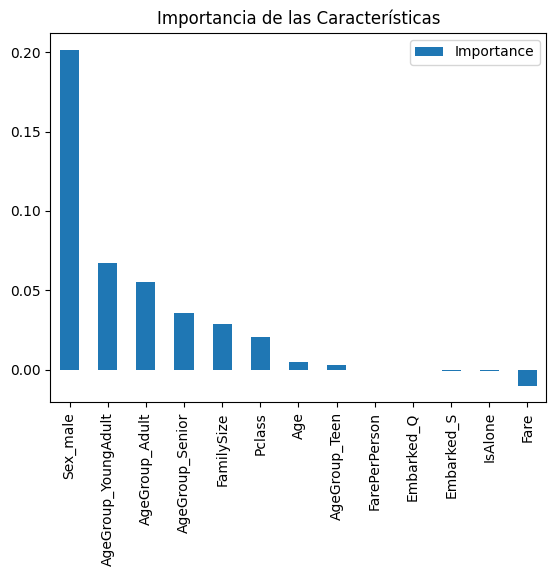

In [11]:
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame(result.importances_mean, index=X.columns, columns=["Importance"])
importance_df.sort_values(by="Importance", ascending=False).plot(kind="bar")
plt.title('Importancia de las Características')
plt.show()

Analizamos la importancia de las características utilizando permutation importance, lo que nos permite identificar cuáles son las variables más influyentes en el modelo.

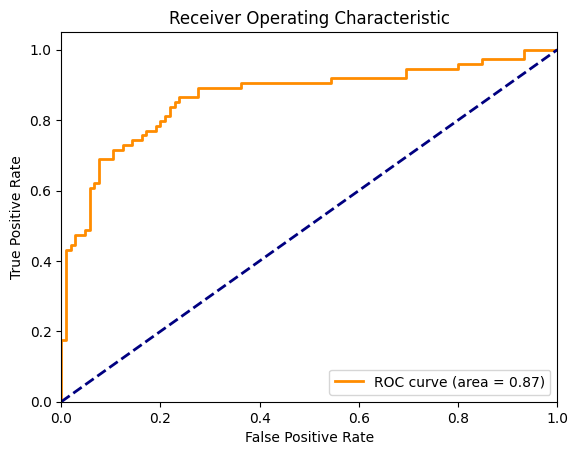

In [12]:
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Graficamos la curva ROC para visualizar la performance del modelo y calcular el área bajo la curva (AUC), lo cual es útil para evaluar la calidad del modelo.

## Conclusiones
A través de este análisis exploratorio de datos, hemos identificado las variables más influyentes en la supervivencia de los pasajeros del Titanic. La regresión logística optimizada resultó ser un modelo predictivo robusto, aunque modelos como Random Forest también mostraron buenos resultados. La importancia de las características y la curva ROC nos permiten confiar en la capacidad de generalización del modelo. Este análisis puede ser expandido con técnicas más avanzadas y la inclusión de más variables para mejorar la precisión.